# Benchmarking Data Normalization Methods with the Dexamethasone Benchmark

This notebook reads in designated meta data and RNA-seq expression data files from a dexamethasone study and performs four normalization methods - counts per million (CPM), log transformation, z-score normalization, and quantile normalization - on the data.

The results of the DEG methods are benchmarked after differential gene and enrichment analysis focused on the NR3C1 transcription factor, the known target of dexamethasone.

The code for characteristic direction and some normalization methods are adapted from Bulk RNA-seq Analysis pipeline appyter: https://appyters.maayanlab.cloud/Bulk_RNA_seq/

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from IPython.display import display
import warnings
import json
import requests
import time
import scipy.stats as ss
from bioinfokit.analys import norm
from maayanlab_bioinformatics.dge.characteristic_direction import characteristic_direction
from maayanlab_bioinformatics.normalization.quantile import quantile_normalize

# Load in Data

Using data from GEO from the study, "The effect of lithium and dexamethasone on fetal rat metatarsal bones transcriptome" 
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE186104 

In [2]:
# Set all variables
meta_class_column_name = 'Sample_characteristics_ch1'
control_name = 'treatment: standard cultivation medium'
treatment = 'treatment: standard cultivation medium + dexamethason'
meta_data_filename = 'GSE186104_series_matrix.txt'
rnaseq_data_filename = 'GSE186104_cross_tabulation_of_gene_expression.txt'
low_expression_threshold = 0.3

In [3]:
# Load in data
try:
    meta_df = pd.read_csv(meta_data_filename, sep="\t", index_col=0, dtype=str)
except:
    print("Error! Please load a metadata file in txt or tsv format")
try:
    expr_df = pd.read_csv(rnaseq_data_filename, index_col=0, sep="\t").sort_index()
except:
    print("Error! Please load a RNA-seq expression file in txt or tsv format")
meta_df.index = meta_df.index.map(str)

# Match samples between the metadata and the datasets
if meta_class_column_name not in meta_df.columns:
    print(f"Error! Column '{meta_class_column_name}' is not in metadata")
    
meta_df = meta_df[meta_df.index.isin(expr_df.columns)]

# sort metadata by class labels; control first
classes = list(meta_df[meta_class_column_name].unique())
classes.remove(control_name)
classes.insert(0, control_name)
meta_df['tmp_class'] = pd.Categorical(meta_df[meta_class_column_name], classes)
meta_df = meta_df.sort_values('tmp_class')
meta_df = meta_df.drop('tmp_class', axis=1)
expr_df = expr_df.loc[:,meta_df.index]
expr_df = expr_df.groupby(expr_df.index).sum()
try:
    assert(meta_df.shape[0]==expr_df.shape[1])
except:
    print("Error! Input files are in a wrong format.")

dataset = dict()
current_dataset = 'rawdata'
dataset[current_dataset] = expr_df
dataset['dataset_metadata'] = meta_df

In [4]:
## Filter out non-expressed genes
expr_df = expr_df.loc[expr_df.sum(axis=1) > 0, :]
## Filter out lowly expressed genes
mask_low_vals = (expr_df > low_expression_threshold).sum(axis=1) > 2
expr_df = expr_df.loc[mask_low_vals, :]
current_dataset += '+filter_genes'
dataset[current_dataset] = expr_df

In [5]:
# Display meta data
meta_df

,Sample_title,Sample_characteristics_ch1
Sample_geo_accession,,
GSM5632354,C1: Untreated control replicate 1,treatment: standard cultivation medium
GSM5632355,C2: Untreated control replicate 2,treatment: standard cultivation medium
GSM5632356,C3: Untreated control replicate 3,treatment: standard cultivation medium
GSM5632357,Dex1: Dexamethason treated sample replicate 1,treatment: standard cultivation medium + dexam...
GSM5632358,Dex2: Dexamethason treated sample replicate 2,treatment: standard cultivation medium + dexam...
GSM5632359,Dex3: Dexamethason treated sample replicate 3,treatment: standard cultivation medium + dexam...


In [6]:
# Display expression data
expr_df

Sample_geo_accession,GSM5632354,GSM5632355,GSM5632356,GSM5632357,GSM5632358,GSM5632359
gene,,,,,,
A1i3,160,60,196,328,274,287
A2m,32,15,19,62,65,36
A3galt2,80,36,75,68,70,47
A4galt,0,0,2,0,1,2
Aaas,541,306,506,295,298,209
...,...,...,...,...,...,...
l7Rn6,392,199,385,174,185,142
mrpl11,374,218,233,144,192,133
mrpl24,611,344,560,222,316,222


# Normalization Methods

### CPM Normalization

In [7]:
# Perform CPM normalization
nm = norm()
nm.cpm(df=expr_df)

In [8]:
# Display CPM results
dataset['cpm'] = nm.cpm_norm
dataset['cpm']

Sample_geo_accession,GSM5632354,GSM5632355,GSM5632356,GSM5632357,GSM5632358,GSM5632359
gene,,,,,,
A1i3,7.288723,5.575553,9.766711,32.616120,23.449715,30.985142
A2m,1.457745,1.393888,0.946773,6.165242,5.562889,3.886638
A3galt2,3.644362,3.345332,3.737262,6.761879,5.990803,5.074222
A4galt,0.000000,0.000000,0.099660,0.000000,0.085583,0.215924
Aaas,24.644996,28.435319,25.214059,29.334620,25.503705,22.564093
...,...,...,...,...,...,...
l7Rn6,17.857372,18.492250,19.184610,17.302454,15.832837,15.330628
mrpl11,17.037391,20.257841,11.610426,14.319272,16.431917,14.358968
mrpl24,27.833812,31.966502,27.904888,22.075545,27.044197,23.967601


### Log Transformation

In [9]:
# Define function for log transformation
def log(data):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        data = data.fillna(0)
        data = np.log2(data+1)
        
    return data

In [10]:
# Display log transformation results
dataset['log_transform'] = log(expr_df)
dataset['log_transform']

Sample_geo_accession,GSM5632354,GSM5632355,GSM5632356,GSM5632357,GSM5632358,GSM5632359
gene,,,,,,
A1i3,7.330917,5.930737,7.622052,8.361944,8.103288,8.169925
A2m,5.044394,4.000000,4.321928,5.977280,6.044394,5.209453
A3galt2,6.339850,5.209453,6.247928,6.108524,6.149747,5.584963
A4galt,0.000000,0.000000,1.584963,0.000000,1.000000,1.584963
Aaas,9.082149,8.262095,8.985842,8.209453,8.224002,7.714246
...,...,...,...,...,...,...
l7Rn6,8.618386,7.643856,8.592457,7.451211,7.539159,7.159871
mrpl11,8.550747,7.774787,7.870365,7.179909,7.592457,7.066089
mrpl24,9.257388,8.430453,9.131857,7.800900,8.308339,7.800900


### Z-Score Normalization 


In [11]:
# Perform Z-score normalization and display results
dataset['z_score'] = expr_df.T.apply(ss.zscore, axis=0).T.dropna()
dataset['z_score']

Sample_geo_accession,GSM5632354,GSM5632355,GSM5632356,GSM5632357,GSM5632358,GSM5632359
gene,,,,,,
A1i3,-0.637529,-1.746276,-0.238381,1.225165,0.626442,0.770579
A2m,-0.319524,-1.200374,-0.993115,1.234917,1.390361,-0.112265
A3galt2,1.099437,-1.691442,0.782292,0.338288,0.465146,-0.993722
A4galt,-0.928477,-0.928477,1.299867,-0.928477,0.185695,1.299867
Aaas,1.502645,-0.439362,1.213410,-0.530264,-0.505473,-1.240956
...,...,...,...,...,...,...
l7Rn6,1.428106,-0.461890,1.359557,-0.706708,-0.598988,-1.020075
mrpl11,1.992039,0.029356,0.218076,-0.901660,-0.297757,-1.040054
mrpl24,1.511902,-0.229340,1.179305,-1.024963,-0.411942,-1.024963


### Quantile Normalization

In [12]:
# Define function for quantile normalization
def qnormalization(data):
  
    X_quantile_norm = quantile_normalize(data)
    return X_quantile_norm

In [13]:
# Perform and display quantile normalization results
dataset['quantile_norm'] = qnormalization(expr_df)
dataset['quantile_norm']

Sample_geo_accession,GSM5632354,GSM5632355,GSM5632356,GSM5632357,GSM5632358,GSM5632359
gene,,,,,,
A1i3,98.716667,81.090476,137.397436,465.511905,322.712963,440.666667
A2m,19.883333,21.168067,13.462046,87.938095,75.261261,57.358491
A3galt2,48.935484,48.470588,52.659420,96.030303,80.606667,74.316239
A4galt,0.000000,0.271847,1.448500,0.255986,1.011297,3.220286
Aaas,337.333333,399.622222,354.562500,417.178571,351.000000,322.863636
...,...,...,...,...,...,...
l7Rn6,243.809524,255.800000,269.727273,248.675926,219.550000,221.277778
mrpl11,232.515152,278.480392,164.066667,205.229167,227.474359,206.515152
mrpl24,379.937500,445.729167,392.633333,318.512821,371.944444,342.000000


In [14]:
# Store methods in a list
methods = ['rawdata+filter_genes', 'cpm', 'log_transform', 'z_score', 'quantile_norm']

# Comparing Methods
### Differential Gene Expression
Signatures for the original dataset and each of the normalized datasets are computed with the characteristic direction method. 

In [15]:
# Function for computing signatures with characteristic direction
def cd_signature(control, treatment, dataset, normalization, meta_class_column_name):
    tmp_normalization = normalization
    
    signatures = dict()
    
    signature_label = normalization
    
    cls1_sample_ids = dataset["dataset_metadata"].loc[dataset["dataset_metadata"][meta_class_column_name]==control, :].index.tolist() #control
    cls2_sample_ids = dataset["dataset_metadata"].loc[dataset["dataset_metadata"][meta_class_column_name]==treatment,:].index.tolist() #case
    
    signature = characteristic_direction(dataset[tmp_normalization].loc[:, cls1_sample_ids], dataset[normalization].loc[:, cls2_sample_ids], calculate_sig=True)
    signature = signature.sort_values("CD-coefficient", ascending=False)
    
    signatures[signature_label] = signature
    
    return signatures

In [16]:
# Get signatures
signatures = {}
for method in methods:
    signature = cd_signature(control_name, treatment, dataset, method, meta_class_column_name)
    signatures.update(signature)

In [17]:
# Display signatures
for i in range(len(methods)):
    display(signatures[method])
    print("Table " + str(i + 1) + ": signatures for " + methods[i] + " dataset")

,CD-coefficient,Significance
gene,,
Col6a3,0.436741,0.072875
Col2a1,0.276925,0.072675
H19,0.271603,0.099041
Col6a1,0.164180,0.072847
Postn,0.149454,0.068171
...,...,...
Col3a1,-0.142871,0.072689
Col1a1,-0.154830,0.072519
Col27a1,-0.201696,0.072646


Table 1: signatures for rawdata+filter_genes dataset


,CD-coefficient,Significance
gene,,
Col6a3,0.436741,0.072875
Col2a1,0.276925,0.072675
H19,0.271603,0.099041
Col6a1,0.164180,0.072847
Postn,0.149454,0.068171
...,...,...
Col3a1,-0.142871,0.072689
Col1a1,-0.154830,0.072519
Col27a1,-0.201696,0.072646


Table 2: signatures for cpm dataset


,CD-coefficient,Significance
gene,,
Col6a3,0.436741,0.072875
Col2a1,0.276925,0.072675
H19,0.271603,0.099041
Col6a1,0.164180,0.072847
Postn,0.149454,0.068171
...,...,...
Col3a1,-0.142871,0.072689
Col1a1,-0.154830,0.072519
Col27a1,-0.201696,0.072646


Table 3: signatures for log_transform dataset


,CD-coefficient,Significance
gene,,
Col6a3,0.436741,0.072875
Col2a1,0.276925,0.072675
H19,0.271603,0.099041
Col6a1,0.164180,0.072847
Postn,0.149454,0.068171
...,...,...
Col3a1,-0.142871,0.072689
Col1a1,-0.154830,0.072519
Col27a1,-0.201696,0.072646


Table 4: signatures for z_score dataset


,CD-coefficient,Significance
gene,,
Col6a3,0.436741,0.072875
Col2a1,0.276925,0.072675
H19,0.271603,0.099041
Col6a1,0.164180,0.072847
Postn,0.149454,0.068171
...,...,...
Col3a1,-0.142871,0.072689
Col1a1,-0.154830,0.072519
Col27a1,-0.201696,0.072646


Table 5: signatures for quantile_norm dataset


### Enrichment Analysis with Enrichr API
This section uses enrichr for enrichment analysis on the signatures to get rankings for NR3C1. Higher rankings (lower numbers) indicate a better method.

In [18]:
# Get gene lists to put into Enrichr
gene_lists = {}
for method in methods:
    gene_lists["{}: up_200".format(method)] = list(signatures[method].head(200).index)
    gene_lists["{}: down_200".format(method)] = list(signatures[method].tail(200).index)
    gene_lists["{}: both_400".format(method)] = gene_lists["{}: up_200".format(method)] + gene_lists["{}: down_200".format(method)]

In [19]:
# Function to get Enrichr Results
def Enrichr_API(enrichr_gene_list, all_libraries):

    all_ranks = []
    all_terms = []
    all_pvalues =[] 
    all_adjusted_pvalues = []
    library_success = []
    short_id = ''

    for library_name in all_libraries : 
        ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/addList'
        genes_str = '\n'.join(enrichr_gene_list)
        description = 'Example gene list'
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }

        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')

        data = json.loads(response.text)
        time.sleep(0.5)
        ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        short_id = data["shortId"]
        gene_set_library = library_name
        response = requests.get(
            ENRICHR_URL + query_string % (user_list_id, gene_set_library)
         )
        if not response.ok:
            raise Exception('Error fetching enrichment results')
        try:
            data = json.loads(response.text)
            results_df  = pd.DataFrame(data[library_name])
            all_ranks.append(list(results_df[0]))
            all_terms.append(list(results_df[1]))
            all_pvalues.append(list(results_df[2]))
            all_adjusted_pvalues.append(list(results_df[6]))
            library_success.append(library_name)
        except:
            print('Error for ' + library_name + ' library')

    return([all_ranks,all_terms,all_pvalues,all_adjusted_pvalues,str(short_id),library_success])

In [20]:
# Get results
results = {}
for gene_list in gene_lists:
    results[gene_list] = Enrichr_API(gene_lists[gene_list], ['ChEA_2016'])

In [21]:
# Extract NR3C1 rankings
# Initialize lists for storing NR3C1 information
names = []
ranks = []
p_val = []
gene_sets = []

# Iterate over each result
for gene_list in gene_lists:
    # Within each gene set, iterate over the transcription factor names
    for i in range(len(results[gene_list][1][0])):
        # If NR3C1 is found, add the information to the lists
        if 'NR3C1' in results[gene_list][1][0][i]:
            names.append(results[gene_list][1][0][i])
            ranks.append(results[gene_list][0][0][i])
            p_val.append(results[gene_list][2][0][i])
            gene_sets.append(gene_list)

In [22]:
df = pd.DataFrame(list(zip(gene_sets, names, ranks, p_val)),
                 columns = ['Gene_Set','Name','Rank','p-value'])
df['Method'] = df.Gene_Set.str.split(":",expand=True)[0]
df

,Gene_Set,Name,Rank,p-value,Method
0,rawdata+filter_genes: up_200,NR3C1 23031785 ChIP-Seq PC12 Mouse,72,0.000049,rawdata+filter_genes
1,rawdata+filter_genes: up_200,NR3C1 21868756 ChIP-Seq MCF10A Human,464,0.460127,rawdata+filter_genes
2,rawdata+filter_genes: down_200,NR3C1 21868756 ChIP-Seq MCF10A Human,418,0.701285,rawdata+filter_genes
3,rawdata+filter_genes: down_200,NR3C1 23031785 ChIP-Seq PC12 Mouse,419,0.703749,rawdata+filter_genes
4,rawdata+filter_genes: both_400,NR3C1 23031785 ChIP-Seq PC12 Mouse,132,0.003234,rawdata+filter_genes
5,rawdata+filter_genes: both_400,NR3C1 21868756 ChIP-Seq MCF10A Human,492,0.586920,rawdata+filter_genes
6,cpm: up_200,NR3C1 23031785 ChIP-Seq PC12 Mouse,72,0.000049,cpm
7,cpm: up_200,NR3C1 21868756 ChIP-Seq MCF10A Human,464,0.460127,cpm
8,cpm: down_200,NR3C1 21868756 ChIP-Seq MCF10A Human,418,0.701285,cpm
9,cpm: down_200,NR3C1 23031785 ChIP-Seq PC12 Mouse,419,0.703749,cpm


### Comparing Rankings

Below are tables and graphs with a summary of the rankings results. From the table of mean rankings, log transformation and z-score seem to perform better overall than the other methods.

In [23]:
# Calculate and sort by mean rank grouping by method and name
df_averages = df.groupby(['Method', 'Name']).mean().sort_values(by='Rank')
df_averages

Rank  \
Method               Name                                               
log_transform        NR3C1 23031785 ChIP-Seq PC12 Mouse     42.666667   
                     NR3C1 21868756 ChIP-Seq MCF10A Human  107.000000   
quantile_norm        NR3C1 23031785 ChIP-Seq PC12 Mouse    110.666667   
z_score              NR3C1 23031785 ChIP-Seq PC12 Mouse    129.666667   
                     NR3C1 21868756 ChIP-Seq MCF10A Human  196.000000   
cpm                  NR3C1 23031785 ChIP-Seq PC12 Mouse    207.666667   
rawdata+filter_genes NR3C1 23031785 ChIP-Seq PC12 Mouse    207.666667   
quantile_norm        NR3C1 21868756 ChIP-Seq MCF10A Human  399.333333   
cpm                  NR3C1 21868756 ChIP-Seq MCF10A Human  458.000000   
rawdata+filter_genes NR3C1 21868756 ChIP-Seq MCF10A Human  458.000000   

                                                            p-value  
Method               Name                                            
log_transform        NR3C1 23031785 ChIP-Seq PC12 Mouse    0.288694  
                     NR3C1 21868756 ChIP-Seq MCF10A Human  0.584258  
quantile_norm        NR3C1 23031785 ChIP-Seq PC12 Mouse    0.043938  
z_score              NR3C1 23031785 ChIP-Seq PC12 Mouse    0.647378  
                     NR3C1 21868756 ChIP-Seq MCF10A Human  0.873685  
cpm                  NR3C1 23031785 ChIP-Seq PC12 Mouse    0.235677  
rawdata+filter_genes NR3C1 23031785 ChIP-Seq PC12 Mouse    0.235677  
quantile_norm        NR3C1 21868756 ChIP-Seq MCF10A Human  0.398989  
cpm                  NR3C1 21868756 ChIP-Seq MCF10A Human  0.582777  
rawdata+filter_genes NR3C1 21868756 ChIP-Seq MCF10A Human  0.582777

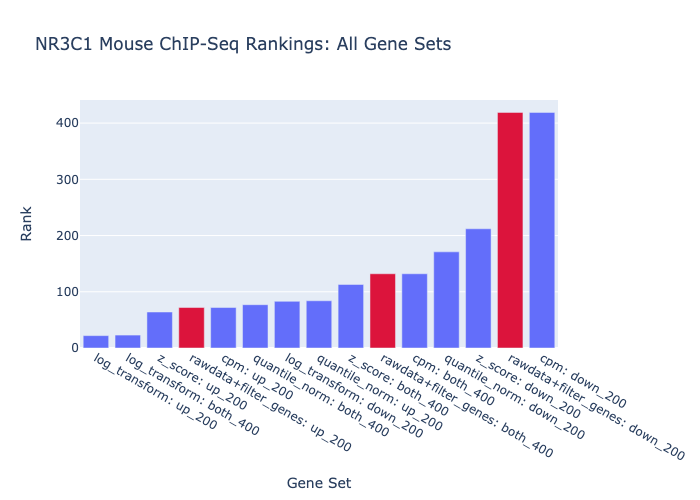

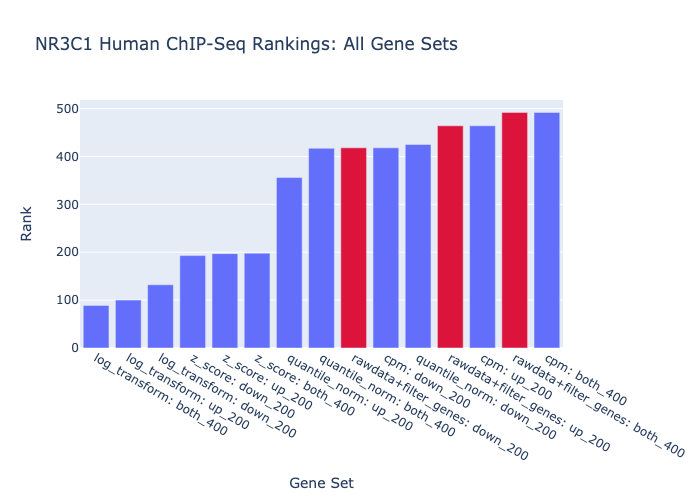

In [24]:
colors = ['#636EFA',] * 15
colors[0] = 'crimson'
colors[1] = 'crimson'
colors[2] = 'crimson'

fig1 = go.Figure()
fig1.add_trace(go.Bar(
    x=df[df['Name'] == "NR3C1 23031785 ChIP-Seq PC12 Mouse"]['Gene_Set'],
    y=df[df['Name'] == "NR3C1 23031785 ChIP-Seq PC12 Mouse"]['Rank'],
    name="Mouse", marker_color=colors))
fig1.update_layout(title_text='NR3C1 Mouse ChIP-Seq Rankings: All Gene Sets',
                   xaxis={'title':{'text':'Gene Set'}, 'categoryorder':'total ascending'}, 
                    yaxis={'title':{'text':'Rank'}})
fig1.show("png")

fig2=go.Figure()
fig2.add_trace(go.Bar(
    x=df[df['Name'] == "NR3C1 21868756 ChIP-Seq MCF10A Human"]['Gene_Set'],
    y=df[df['Name'] == "NR3C1 21868756 ChIP-Seq MCF10A Human"]['Rank'],
    name="Human", marker_color=colors))
fig2.update_layout(title_text='NR3C1 Human ChIP-Seq Rankings: All Gene Sets',
                xaxis={'title':{'text':'Gene Set'}, 'categoryorder':'total ascending'}, 
                yaxis={'title':{'text':'Rank'}})
fig2.show("png")

In [25]:
df_averages = df_averages.reset_index()

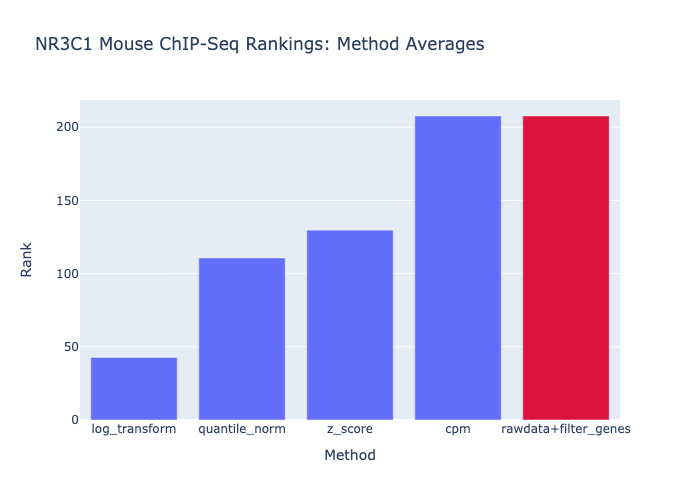

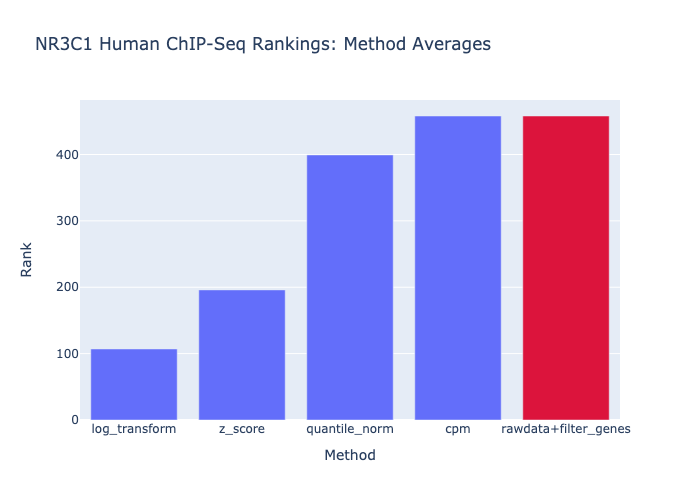

In [26]:
colors = ['#636EFA',] * 5
colors[4] = 'crimson'

fig3 = go.Figure()
fig3.add_trace(go.Bar(
    x=df_averages[df_averages['Name'] == "NR3C1 23031785 ChIP-Seq PC12 Mouse"]['Method'],
    y=df_averages[df_averages['Name'] == "NR3C1 23031785 ChIP-Seq PC12 Mouse"]['Rank'],
    name="Mouse", marker_color=colors))
fig3.update_layout(title_text='NR3C1 Mouse ChIP-Seq Rankings: Method Averages',
                   xaxis={'title':{'text':'Method'}, 'categoryorder':'total ascending'}, 
                    yaxis={'title':{'text':'Rank'}})
fig3.show("png")

fig4=go.Figure()
fig4.add_trace(go.Bar(
    x=df_averages[df_averages['Name'] == "NR3C1 21868756 ChIP-Seq MCF10A Human"]['Method'],
    y=df_averages[df_averages['Name'] == "NR3C1 21868756 ChIP-Seq MCF10A Human"]['Rank'],
    name="Human", marker_color=colors))
fig4.update_layout(title_text='NR3C1 Human ChIP-Seq Rankings: Method Averages',
                xaxis={'title':{'text':'Method'}, 'categoryorder':'total ascending'}, 
                yaxis={'title':{'text':'Rank'}})
fig4.show("png")

The graphs above suggest that most normalization methods led to better results than no normalization. Only CPM was tied with no normalization. A Wilcoxon test is also performed to further compare if the results of different methods are significantly different from no normalization. Smaller p-values indicate greater likelihood of the methods being different.

In [27]:
# Getting ranks of each method as a list
raw_ranks = df[df["Method"] == 'rawdata+filter_genes']['Rank'].tolist()
significance_threshold = 0.05

for i in range(len(methods) - 1):
    norm_ranks = df[df["Method"] == methods[i + 1]]['Rank'].tolist()
    try:
        w, p = ss.wilcoxon(norm_ranks, raw_ranks)
        print("The p-value for " + methods[i + 1] + " vs. no normalization is " + str(p))
        if p < significance_threshold:
            print(methods[i + 1] + " is statistically significantly different from no normalization")
        else:
            print(methods[i + 1] + " is not statistically significantly different from no normalization")
        print("")
    except:
        print("Wilcoxon test for " + methods[i + 1] + " vs. no normalization can not be done because of a tie.")
        print("")

Wilcoxon test for cpm vs. no normalization can not be done because of a tie.

The p-value for log_transform vs. no normalization is 0.03125
log_transform is statistically significantly different from no normalization

The p-value for z_score vs. no normalization is 0.03125
z_score is statistically significantly different from no normalization

The p-value for quantile_norm vs. no normalization is 0.15625
quantile_norm is not statistically significantly different from no normalization



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_morestats.py:3145: UserWarning:

Exact p-value calculation does not work if there are ties. Switching to normal approximation.

